In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
l_start = './LOGS_start/'
l_to_10kK = './LOGS_to_10kK/'
l_to_rsg = './LOGS_to_rsg/'
l_rsg = './LOGS_rsg/'
l_postrsg = './LOGS_postrsg/'

In [3]:
def read_history(logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    hist = pd.read_csv(logs+'history.data',sep='\s+',skiprows=5)
    evo_stage = '_'.join(logs.split('_')[1:]).rstrip('/')
    hist['EvoStage'] = [evo_stage for i in range(len(hist))]
    hist['LOGS'] = [logs for i in range(len(hist))]
    
    return hist

def read_profile_index(logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    profile_index = pd.read_csv(logs+'profiles.index',
                                names=['model_number','priority','profile_num'],
                                sep='\s+',skiprows=1)
    evo_stage = '_'.join(logs.split('_')[1:]).rstrip('/')
    profile_index['EvoStage'] = [evo_stage for i in range(len(profile_index))]
    profile_index['LOGS'] = [logs for i in range(len(profile_index))]
    
    return profile_index

In [4]:
read_profile_index(l_start)

,model_number,priority,profile_num,EvoStage,LOGS
0,1,2,1,start,./LOGS_start/
1,100,1,2,start,./LOGS_start/
2,200,1,3,start,./LOGS_start/
3,215,3,4,start,./LOGS_start/


In [5]:
all_hist = pd.concat([read_history(l) for l in [l_start,l_to_10kK,l_to_rsg,l_rsg,l_postrsg]]).reset_index(drop=True)
all_index = pd.concat([read_profile_index(l) for l in [l_start,l_to_10kK,l_to_rsg,l_rsg,l_postrsg]]).reset_index(drop=True)
all_index

,model_number,priority,profile_num,EvoStage,LOGS
0,1,2,1,start,./LOGS_start/
1,100,1,2,start,./LOGS_start/
2,200,1,3,start,./LOGS_start/
3,215,3,4,start,./LOGS_start/
4,216,2,1,to_10kK,./LOGS_to_10kK/
...,...,...,...,...,...
256,2197,1,133,postrsg,./LOGS_postrsg/
257,2198,1,134,postrsg,./LOGS_postrsg/
258,2199,1,135,postrsg,./LOGS_postrsg/
259,2200,1,136,postrsg,./LOGS_postrsg/


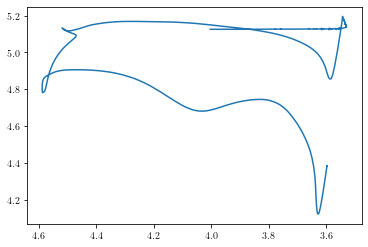

In [6]:
plt.plot(all_hist['log_Teff'],all_hist['log_L'])
plt.gca().invert_xaxis()

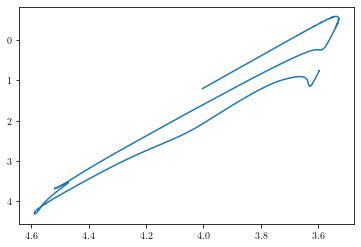

In [60]:
plt.plot(all_hist['log_Teff'],all_hist['log_g'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

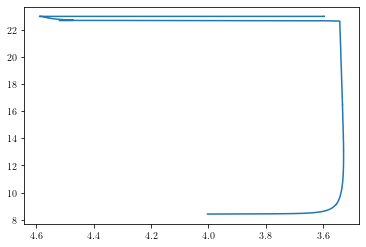

In [65]:
plt.plot(all_hist['log_Teff'],all_hist['star_mass'])
plt.gca().invert_xaxis()

In [7]:
def dist_from_point(hist, logTeff, logL):
    mu = np.array([[logTeff,logL]])
    cov = np.array([[0.015,0.0],[0.0,0.1]])
    diff_vec = hist[['log_Teff','log_L']].values-mu
    squ_dist = np.array([np.dot(diff,np.linalg.solve(cov, diff)) for diff in diff_vec])
    return np.sqrt(squ_dist)

def model_close_to_point(hist, logTeff, logL):
    dist = dist_from_point(hist, logTeff, logL)
    closest = hist.iloc[np.argmin(dist)]
    return closest

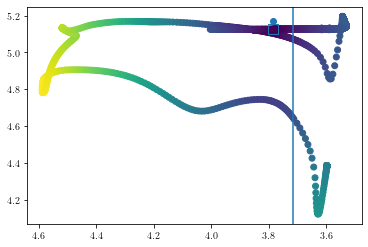

In [72]:
t_test, l_test = 3.784, 5.169 #HD 268687
plt.scatter(all_hist['log_Teff'],all_hist['log_L'],c=dist_from_point(all_hist,t_test,l_test))
plt.gca().invert_xaxis()
plt.scatter(t_test,l_test)
closest = model_close_to_point(all_hist, t_test, l_test)
plt.scatter(closest['log_Teff'],closest['log_L'],marker='s',facecolor="None",
           edgecolor='C0',s=100)
plt.axvline(np.log10(5200))

In [9]:
close_model = closest['model_number']
close_prof = all_index['profile_num'][all_index['model_number']==close_model].values[0]
close_dir = closest['LOGS']
close_model,close_dir,close_prof

(2136, './LOGS_postrsg/', 72)

In [71]:
10.0**closest[['log_Teff','log_R']]

log_Teff    6081.219584
log_R        329.350589
Name: 2135, dtype: object

In [10]:
def read_profile(profile_num = 1, logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    profile = pd.read_csv(logs+f'profile{profile_num}.data',sep='\s+',skiprows=5)
    evo_stage = '_'.join(logs.split('_')[1:]).rstrip('/')
    profile['EvoStage'] = [evo_stage for i in range(len(profile))]
    profile['LOGS'] = [logs for i in range(len(profile))]
    
    return profile

In [11]:
profile = read_profile(profile_num=close_prof, logs=close_dir)

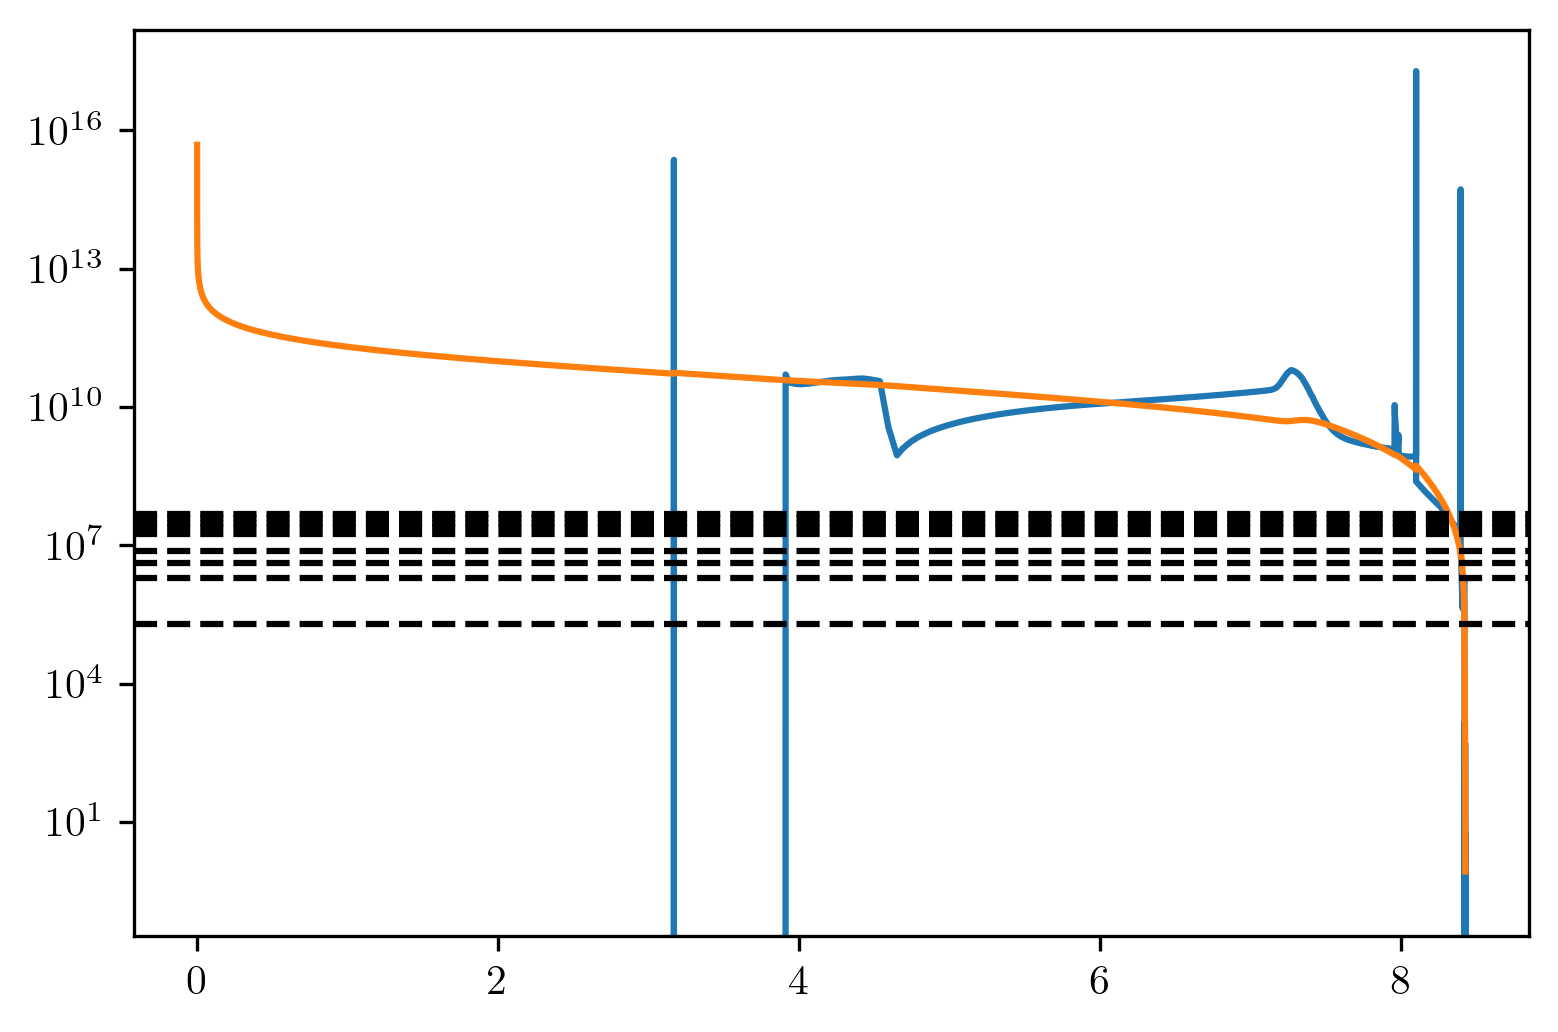

In [81]:
fig = plt.figure(dpi=300)
plt.plot(profile['mass'],profile['brunt_N2']*closest['dynamic_timescale']**2.0)
plt.plot(profile['mass'],profile['lamb_S2']*closest['dynamic_timescale']**2.0)
import h5py as h5
test_tic = 29984014
with h5.File('../../TESS/code/prewhitening.hdf5','r') as freqs:
    good_fs = freqs[f'{test_tic}/good_fs'][()][:,0]

import astropy.units as u
f_rad_per_sec = 2*np.pi*good_fs * (u.rad/u.day).to(u.rad/u.second)
for f in f_rad_per_sec:
    plt.axhline(f**2.0*closest['dynamic_timescale']**2.0,ls='--',c='k')

plt.yscale('log')

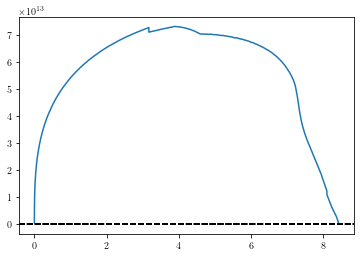

In [79]:
plt.plot(profile['mass'],((profile['csound'].values/2.0/profile['pressure_scale_height'].values)*u.Hz).to(1.0/u.day))
with h5.File('../../TESS/code/prewhitening.hdf5','r') as freqs:
    good_fs = freqs[f'{test_tic}/good_fs'][()][:,0]

import astropy.units as u
f_rad_per_sec = 2*np.pi*good_fs * (u.rad/u.day).to(u.rad/u.second)
for f in good_fs:
    plt.axhline(f,ls='--',c='k')

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


(1, 10000000000000.0)

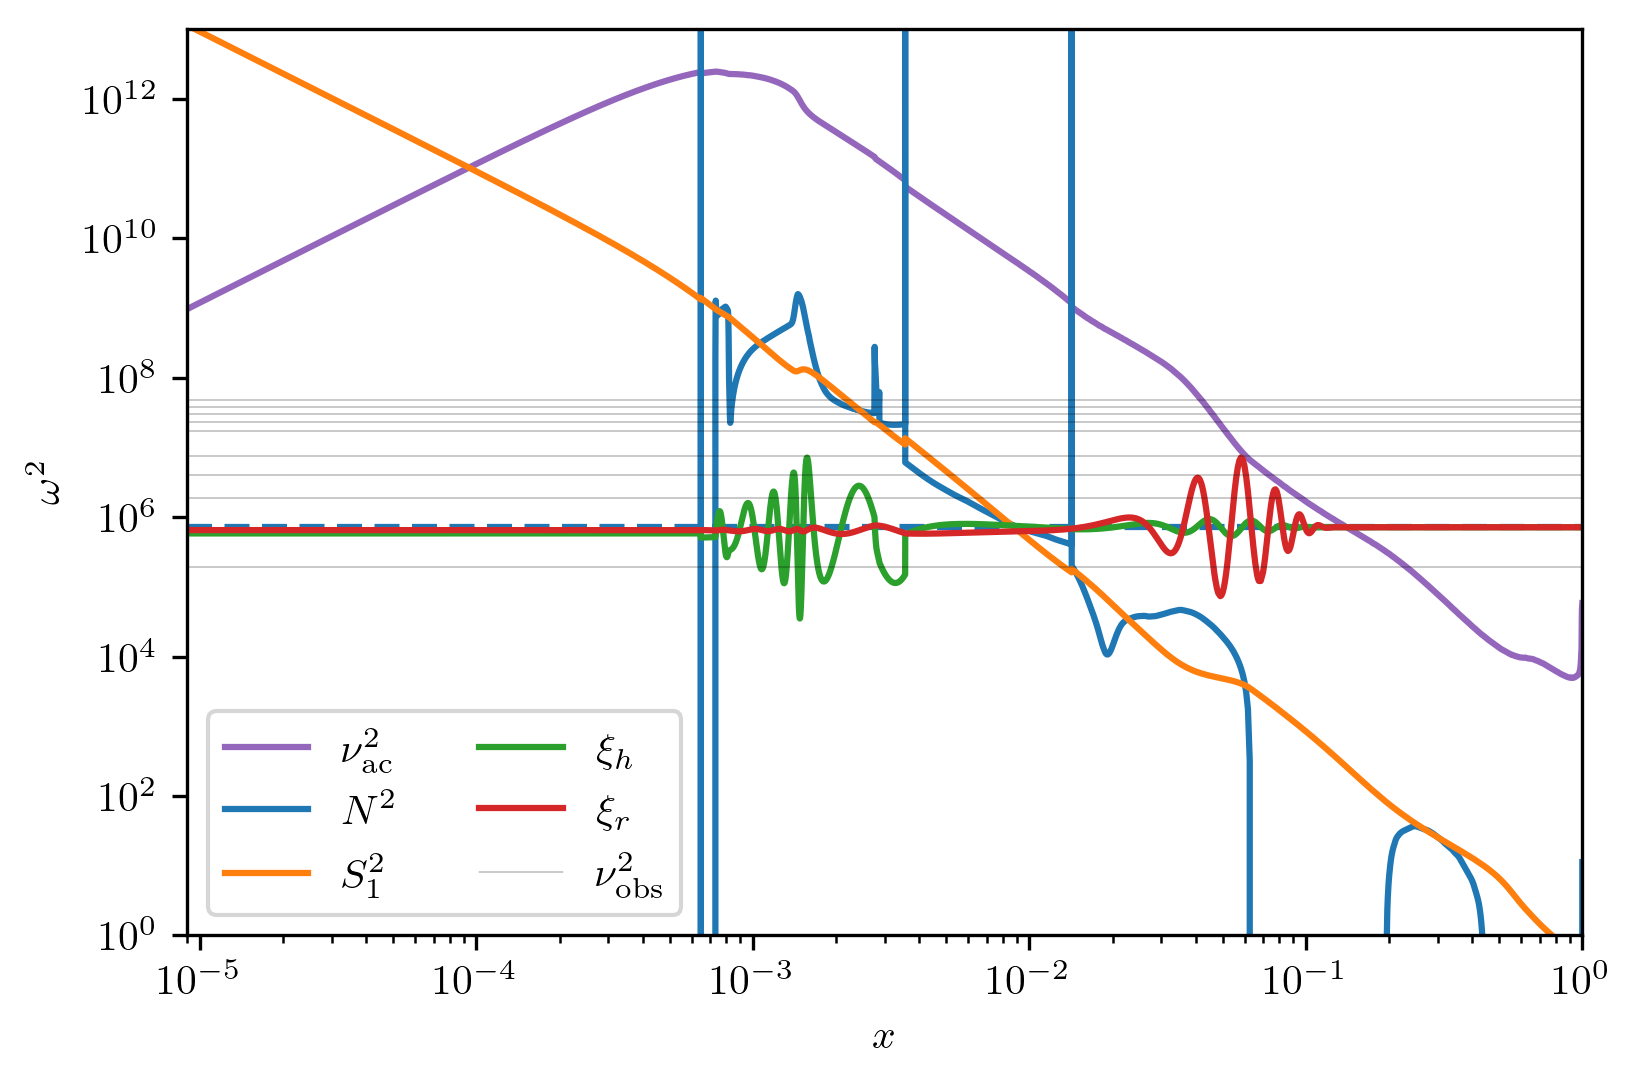

In [126]:
import pygyre as pg

d = pg.read_output('../GYRE_explore/detail.l1.m+0.n-1.h5')

l = d.meta['l']
omega = d.meta['omega']

x = d['x']
V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = d['As']/d['c_1']
d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)

# Plot the propagation diagram

prof_logx = np.log10(profile['radius'])-closest['log_R']
prof_x = np.power(10.0,prof_logx)

plt.figure(dpi=300)

H_p = (profile['pressure_scale_height'].values*u.Rsun).to(u.cm)
cs = profile['csound'].values * u.cm / u.s
nu_cutoff = (cs / (2.0*H_p)).to(1.0/u.day)
nu_cutoff_dim = (2*np.pi*nu_cutoff.to(u.Hz)*(tdyn*u.second)).decompose().value

plt.plot(prof_x,nu_cutoff_dim**2.0,label=r'$\nu_{\rm ac}^2$',c='C4')

plt.plot(d['x'], d['N2'], label='$N^2$')
plt.plot(d['x'], d['Sl2'], label='$S_1^2$')

plt.axhline(omega.real**2, dashes=(4,2))
plt.semilogx(d['x'],omega.real**2*np.power(10.0,d['xi_h'].real/d['xi_h'].real.max()),label=r'$\xi_h$')
plt.semilogx(d['x'],omega.real**2*np.power(10.0,d['xi_r'].real/d['xi_r'].real.max()),label=r'$\xi_r$')
test_tic = 29984014
import h5py as h5
with h5.File('../../TESS/code/prewhitening.hdf5','r') as freqs:
    good_fs = freqs[f'{test_tic}/good_fs'][()][:,0]

f_rad_per_sec = 2*np.pi*good_fs * (u.rad/u.day).to(u.rad/u.second)
tdyn = closest['dynamic_timescale']
for i,f in enumerate(f_rad_per_sec):
    label = None
    if i == 0 :
        label = r'$\nu_{\rm obs}^2$'
    plt.axhline(f**2.0*tdyn**2.0, c='k',lw=0.1,label=label)


plt.xlabel('$x$')
plt.ylabel('$\omega^2$')


plt.yscale('log')

plt.legend(loc='lower left',ncol=2)

plt.xlim(9e-6,1)
plt.ylim(1, 1e13)

In [139]:
from astropy import units as u,constants as c
R = np.power(10.0,closest['log_R'])*u.Rsun
M = closest['star_mass']*u.Msun
tdyn = np.sqrt((R**3.0) / (2*c.G*M))
closest['dynamic_timescale'],tdyn.to(u.second),R

(20605330.38956768,
 <Quantity 2318914.39369195 s>,
 <Quantity 329.35058929 solRad>)

In [134]:
closest['star_mass']

8.428111691178295

In [100]:
for i in closest.index:
    print(i)

model_number
num_zones
star_age
log_dt
star_mass
log_xmstar
log_abs_mdot
mass_conv_core
conv_mx1_top
conv_mx1_bot
conv_mx2_top
conv_mx2_bot
mx1_top
mx1_bot
mx2_top
mx2_bot
mix_type_1
mix_qtop_1
mix_type_2
mix_qtop_2
mix_type_3
mix_qtop_3
mix_type_4
mix_qtop_4
mix_type_5
mix_qtop_5
mix_type_6
mix_qtop_6
mix_type_7
mix_qtop_7
mix_type_8
mix_qtop_8
mix_type_9
mix_qtop_9
mix_type_10
mix_qtop_10
mix_type_11
mix_qtop_11
mix_type_12
mix_qtop_12
mix_type_13
mix_qtop_13
mix_type_14
mix_qtop_14
mix_type_15
mix_qtop_15
mix_type_16
mix_qtop_16
mix_type_17
mix_qtop_17
mix_type_18
mix_qtop_18
mix_type_19
mix_qtop_19
mix_type_20
mix_qtop_20
mix_type_21
mix_qtop_21
mix_type_22
mix_qtop_22
mix_type_23
mix_qtop_23
mix_type_24
mix_qtop_24
mix_type_25
mix_qtop_25
mix_type_26
mix_qtop_26
mix_type_27
mix_qtop_27
mix_type_28
mix_qtop_28
mix_type_29
mix_qtop_29
mix_type_30
mix_qtop_30
mix_type_31
mix_qtop_31
mix_type_32
mix_qtop_32
mix_type_33
mix_qtop_33
mix_type_34
mix_qtop_34
mix_type_35
mix_qtop_35
mix_ty

In [58]:
closest['dynamic_timescale']

20605330.38956768

In [55]:
from astropy.constants import G,L_sun
import astropy.units as u
M_r = profile['mass'].values*u.Msun
r = (profile['radius'].values*u.Rsun).to(u.cm)
rho = profile['density'].values * u.gram / (u.cm ** 3.0)
l = np.power(10.0,profile['logL'].values)*L_sun
cp = profile['cp'].values * u.erg / u.Kelvin
T = profile['temperature'].values*u.Kelvin
P = profile['pressure'].values*u.erg / (u.cm ** 3.0)
therm_div_dyn = ((4.0 * np.pi * r**2.0)*rho*cp*T) * np.sqrt(P/rho) / (l.to(u.erg / u.s))

In [50]:
np.sqrt(P/rho)

<Quantity [6.40376807e+05, 6.40376810e+05, 6.40376820e+05, ...,
           1.24314482e+08, 1.24314963e+08, 1.24315366e+08] erg(1/2) / g(1/2)>

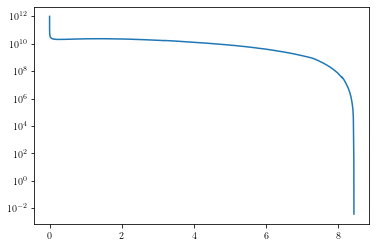

In [54]:
plt.plot(M_r,therm_div_dyn.to(u.gram))
plt.yscale('log')

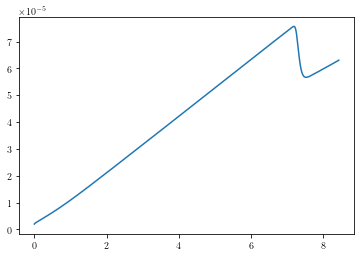

In [57]:
plt.plot(M_r, M_r.value/np.power(10.0,profile['logL']))

In [52]:
therm_div_dyn.unit.decompose()

Unit("0.001 kg")

In [13]:
for c in profile.columns:
    print(c)

zone
mass
logR
logT
logRho
logP
x_mass_fraction_H
y_mass_fraction_He
z_mass_fraction_metals
logdq
dq_ratio
q
log_g
radius
velocity
v_div_r
pressure_scale_height
mmid
logxq
temperature
density
entropy
pressure
prad
pgas
logPgas
pgas_div_ptotal
eta
mu
grada
cv
cp
free_e
csound
v_div_csound
eps_grav
eps_nuc
non_nuc_neu
pp
cno
tri_alfa
c_alpha
n_alpha
o_alpha
ne_alpha
na_alpha
mg_alpha
si_alpha
s_alpha
ar_alpha
ca_alpha
ti_alpha
cr_alpha
fe_co_ni
c12_c12
c12_o16
o16_o16
pnhe4
photo
ni56_co56
co56_fe56
other
abar
ye
h1
he3
he4
c12
n14
o16
ne20
mg24
c12.1
n14.1
o16.1
log_opacity
kap_frac_lowT
kap_frac_highT
kap_frac_Type2
kap_frac_Compton
luminosity
logL
total_energy
mlt_mixing_length
mlt_mixing_type
log_conv_vel
gradT
gradr
grad_temperature
grad_density
gradL
sch_stable
ledoux_stable
gradT_sub_grada
conv_vel_div_csound
log_mlt_D_mix
gradr_sub_grada
mixing_type
log_D_mix
log_D_conv
log_D_semi
log_D_ovr
log_D_thrm
tau
logtau
omega
log_omega
log_j_rot
log_J_div_M53
log_J_inside
log_abs_shear
i

In [43]:
profile['pressure'].values

array([6.95326300e+01, 6.95326357e+01, 6.95326556e+01, ...,
       1.32699256e+19, 1.32702490e+19, 1.32705206e+19])